In [1]:
%matplotlib inline


Language Translation with Transformer
=====================================

This tutorial shows, how to train a translation model from scratch using
Transformer. We will be using Multi30k dataset to train a German to English translation model.



Data Processing
---------------

torchtext has utilities for creating datasets that can be easily
iterated through for the purposes of creating a language translation
model. In this example, we show how to tokenize a raw text sentence,
build vocabulary, and numericalize tokens into tensor.

To run this tutorial, first install spacy using pip or conda. Next,
download the raw data for the English and German Spacy tokenizers from
https://spacy.io/usage/models



In [2]:
import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor
import io
import time
from utils import *
from my_transformer import *
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

In [3]:
pth_base = "./.data/multi30k/task1/raw/"
train_pths = ('train.de.gz', 'train.en.gz')
val_pths = ('val.de.gz', 'val.en.gz')
test_pths = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')
train_filepaths = [extract_archive(pth_base + pth)[0] for pth in train_pths]
val_filepaths = [extract_archive(pth_base + pth)[0] for pth in val_pths]
test_filepaths = [extract_archive(pth_base + pth)[0] for pth in test_pths]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

de_vocab = build_vocab(train_filepaths[0], de_tokenizer, min_freq=1)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer, min_freq=1)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de.rstrip("\n"))], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en.rstrip("\n"))], dtype=torch.long)
        data.append((de_tensor_, en_tensor_))

    return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
print(device)
print("train size:", len(train_data))
print("val size:", len(val_data))
print("test size:", len(test_data))
print("de vocab size:", len(de_vocab))
print("en vocab size:", len(en_vocab))

cuda
train size: 29000
val size: 1014
test size: 1000
de vocab size: 19215
en vocab size: 10838


DataLoader
----------

The last torch specific feature we’ll use is the DataLoader, which is
easy to use since it takes the data as its first argument. Specifically,
as the docs say: DataLoader combines a dataset and a sampler, and
provides an iterable over the given dataset. The DataLoader supports
both map-style and iterable-style datasets with single- or multi-process
loading, customizing loading order and optional automatic batching
(collation) and memory pinning.

Please pay attention to collate_fn (optional) that merges a list of
samples to form a mini-batch of Tensor(s). Used when using batched
loading from a map-style dataset.




In [5]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 256
SRC_VOCAB_SIZE = len(de_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
EMB_SIZE = 512
FFN_HID_DIM = 1024
NHEAD = 8
DROPOUT = 0.1
NUM_EPOCHS = 100
model_name = "./models/transformer-5-20-4"


PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

Transformer!
------------

Transformer is a Seq2Seq model introduced in `“Attention is all you
need” <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>`__
paper for solving machine translation task. Transformer model consists
of an encoder and decoder block each containing fixed number of layers.

Encoder processes the input sequence by propogating it, through a series
of Multi-head Attention and Feed forward network layers. The output from
the Encoder referred to as ``memory``, is fed to the decoder along with
target tensors. Encoder and decoder are trained in an end-to-end fashion
using teacher forcing technique.




Text tokens are represented by using token embeddings. Positional
encoding is added to the token embedding to introduce a notion of word
order.




We create a ``subsequent word`` mask to stop a target word from
attending to its subsequent words. We also create masks, for masking
source and target padding tokens




Define model parameters and instantiate model 




In [6]:
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                 EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM, DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 36,718,678 trainable parameters


In [8]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(train_iter):
      src = src.to(device)
      tgt = tgt.to(device)
            
      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, PAD_IDX, device)

      logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
      
      optimizer.zero_grad()
      
      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, (src, tgt) in (enumerate(valid_iter)):
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, PAD_IDX, device)

    logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)

## Train Model and Save Checkpoints




In [9]:
train_loss_curve = []
val_loss_curve = []
min_val_loss = 999

In [10]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss = train_epoch(transformer, train_iter, optimizer)
    end_time = time.time()
    val_loss = evaluate(transformer, valid_iter)
    if val_loss < min_val_loss:
        transformer.eval()
        torch.save(transformer, model_name+"-best.pth.tar")
    if epoch % 30 == 0:
        transformer.eval()
        torch.save(transformer, model_name+"-ckpt-"+str(epoch)+".pth.tar")
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 6.604, Val loss: 5.335, Epoch time = 72.387s
Epoch: 2, Train loss: 5.081, Val loss: 4.817, Epoch time = 72.852s
Epoch: 3, Train loss: 4.645, Val loss: 4.396, Epoch time = 73.030s
Epoch: 4, Train loss: 4.300, Val loss: 4.140, Epoch time = 72.995s
Epoch: 5, Train loss: 4.093, Val loss: 3.992, Epoch time = 73.015s
Epoch: 6, Train loss: 3.953, Val loss: 3.885, Epoch time = 73.528s
Epoch: 7, Train loss: 3.846, Val loss: 3.824, Epoch time = 72.983s
Epoch: 8, Train loss: 3.755, Val loss: 3.741, Epoch time = 73.025s
Epoch: 9, Train loss: 3.672, Val loss: 3.678, Epoch time = 73.496s
Epoch: 10, Train loss: 3.597, Val loss: 3.624, Epoch time = 73.196s
Epoch: 11, Train loss: 3.525, Val loss: 3.559, Epoch time = 72.977s
Epoch: 12, Train loss: 3.460, Val loss: 3.510, Epoch time = 72.647s
Epoch: 13, Train loss: 3.397, Val loss: 3.449, Epoch time = 72.879s
Epoch: 14, Train loss: 3.338, Val loss: 3.411, Epoch time = 73.361s
Epoch: 15, Train loss: 3.284, Val loss: 3.368, Epoch time

KeyboardInterrupt: 

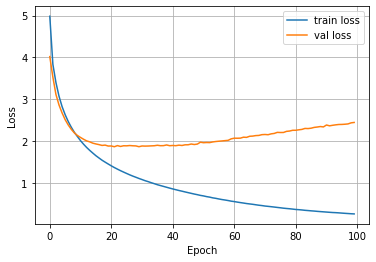

In [11]:
plt.plot(train_loss_curve)
plt.plot(val_loss_curve)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("train loss","val loss"))
plt.savefig("./images/" + model_name.split(sep="/")[-1] + ".png")
plt.show()

In [12]:
translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu .", de_vocab, en_vocab, de_tokenizer, BOS_IDX, EOS_IDX, device)

' A group of people stand in front of an igloo . '

## Save Transformer

In [13]:
transformer.eval()
torch.save(transformer, model_name + ".pth.tar")

References
----------

1. Attention is all you need paper.
   https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
2. The annotated transformer. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding 

